In [41]:
!pip install numpy pandas scikit-learn wordcloud seaborn matplotlib faiss-cpu nltk 
!pip install --upgrade wordcloud pillow

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [42]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_distances
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import faiss
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')

In [43]:
# # Download NLTK data
# nltk.download('punkt')
# nltk.download('punkt_tab')
# nltk.download('stopwords')
# nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/bittu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/bittu/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/bittu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/bittu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [44]:
# Initialize lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) | {
    'movie', 'film', 'story', 'director', 'cast', 'released', 'production',
    'is', 'am', 'are', 'was', 'were', 'should', 'could', 'would', 'the', 'a', 'an',
    'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by'
}

In [45]:
# Load and preprocess data
df = pd.read_csv('TMDB_movie_dataset_v11.csv')

In [46]:
df

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,backdrop_path,...,original_title,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages,keywords
0,27205,Inception,8.364,34495,Released,2010-07-15,825532764,148,False,/8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg,...,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,/oYuLEt3zVCKq57qu2F8dT7NIa6f.jpg,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc..."
1,157336,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,False,/pbrkL804c8yAv3zBZR4QPEafpAR.jpg,...,Interstellar,The adventures of a group of explorers who mak...,140.241,/gEU2QniE6E77NI6lCU6MxlNBvIx.jpg,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,..."
2,155,The Dark Knight,8.512,30619,Released,2008-07-16,1004558444,152,False,/nMKdUUepR0i5zn0y1T4CsSB5chy.jpg,...,The Dark Knight,Batman raises the stakes in his war on crime. ...,130.643,/qJ2tW6WMUDux911r6m7haRef0WH.jpg,Welcome to a world without rules.,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f..."
3,19995,Avatar,7.573,29815,Released,2009-12-15,2923706026,162,False,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,...,Avatar,"In the 22nd century, a paraplegic Marine is di...",79.932,/kyeqWdyUXW608qlYkRqosgbbJyK.jpg,Enter the world of Pandora.,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish","future, society, culture clash, space travel, ..."
4,24428,The Avengers,7.710,29166,Released,2012-04-25,1518815515,143,False,/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg,...,The Avengers,When an unexpected enemy emerges and threatens...,98.082,/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg,Some assembly required.,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"English, Hindi, Russian","new york city, superhero, shield, based on com..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1231673,779857,My Mother Is Just One,0.000,0,Released,2018-12-01,0,6,False,NaN,...,Mama mea e numai una,A young girl organizes a picnic for her boyfri...,0.600,NaN,NaN,NaN,NaN,Romania,NaN,NaN
1231674,779860,Koschei the Deathless,0.000,0,Released,2020-05-10,0,13,False,/9NzTPIwZmsv3SC0HtRUJeLqeY8b.jpg,...,Koschei the Deathless,When Richard Marlow buys a taxidermy hare from...,0.840,/jgqY93UC8etJKsLRrguQ6Jjkpny.jpg,NaN,Comedy,Backbone Theatre and Film,United Kingdom,English,"magic realism, russian history, based on myths..."
1231675,779862,Kei to the Mountain,0.000,0,Released,2020-12-25,0,78,False,NaN,...,Kei to the Mountain,Marty and Moog take their modified cars off th...,0.600,NaN,NaN,Documentary,Might Car Mods,NaN,English,NaN
1231676,779864,My Grandparents,0.000,0,Released,1972-01-01,0,0,False,NaN,...,My Grandparents,NaN,0.600,NaN,NaN,NaN,NaN,Switzerland,No Language,NaN


In [47]:
df.columns

Index(['id', 'title', 'vote_average', 'vote_count', 'status', 'release_date',
       'revenue', 'runtime', 'adult', 'backdrop_path', 'budget', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'tagline', 'genres',
       'production_companies', 'production_countries', 'spoken_languages',
       'keywords'],
      dtype='object')

In [48]:
# Drop rows where all columns are null
df = df.dropna(how='all')

In [49]:
# Select relevant columns
columns_to_keep = [
    'title', 'vote_average', 'vote_count', 'status', 'release_date',
    'revenue', 'runtime', 'adult', 'budget', 'original_language',
    'original_title', 'overview', 'popularity', 'tagline', 'genres',
    'production_companies', 'production_countries', 'spoken_languages', 'keywords'
]
df = df[columns_to_keep]

In [50]:
# Drop rows with any null values
df = df.dropna()
# Drop approximately half of the rows with any null values
# null_rows = df[df[columns_to_keep].isnull().any(axis=1)]
# non_null_rows = df[~df[columns_to_keep].isnull().any(axis=1)]
# np.random.seed(42)  # For reproducibility
# drop_indices = np.random.choice(null_rows.index, size=int(len(null_rows) / 2), replace=False)
# df = pd.concat([non_null_rows, null_rows.drop(drop_indices)]).reset_index(drop=True)

In [51]:
df

,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,budget,original_language,original_title,overview,popularity,tagline,genres,production_companies,production_countries,spoken_languages,keywords
0,Inception,8.364,34495,Released,2010-07-15,825532764,148,False,160000000,en,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc..."
1,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,False,165000000,en,Interstellar,The adventures of a group of explorers who mak...,140.241,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,..."
2,The Dark Knight,8.512,30619,Released,2008-07-16,1004558444,152,False,185000000,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,130.643,Welcome to a world without rules.,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f..."
3,Avatar,7.573,29815,Released,2009-12-15,2923706026,162,False,237000000,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",79.932,Enter the world of Pandora.,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish","future, society, culture clash, space travel, ..."
4,The Avengers,7.710,29166,Released,2012-04-25,1518815515,143,False,220000000,en,The Avengers,When an unexpected enemy emerges and threatens...,98.082,Some assembly required.,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"English, Hindi, Russian","new york city, superhero, shield, based on com..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230889,Blood-Red Ox,0.000,0,Released,2021-06-01,0,94,False,0,en,Blood-Red Ox,Amir and Amat are invited to a trip into the S...,2.069,"In the glory of their fall, you can hear Baham...","Horror, Thriller",Kantrr Films,"Bolivia, United States of America","English, Spanish",gay theme
1230962,Finding Courage,0.000,0,Released,2020-09-18,0,120,False,0,en,Finding Courage,A former Chinese journalist living in exile in...,0.612,A true story of one family who dared to be free.,Documentary,Swoop Films,United States of America,"Mandarin, English",falun gong
1231160,Party in the Park 1999,0.000,0,Released,2002-05-02,0,155,False,0,en,Party in the Park 1999,Location - London's Hyde Park Date - 4th July...,0.914,Live Music! at Party In The Park 99,Music,"TDK Mediactive, Fun International Productions",United Kingdom,English,concert
1231161,Youp.,0.000,0,Released,2020-12-24,0,60,False,0,nl,Youp.,Colleagues about the comedian in the run-up to...,0.600,Colleagues about the comedian in the run-up to...,"Documentary, Comedy",BNNVARA,Netherlands,Dutch,youp


In [52]:
# Preprocess text with lemmatization
def preprocess_text(text):
    if pd.isna(text):
        return ''  # Handle potential NaN values
    tokens = word_tokenize(str(text).lower())
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalnum() and token not in stop_words]
    return ' '.join(tokens)

In [53]:
# Combine textual columns for TF-IDF
textual_columns = [
    'title', 'overview', 'keywords', 'genres', 'tagline',
    'production_companies', 'production_countries', 'spoken_languages',
    'original_language', 'original_title', 'status'
]
df['text'] = df[textual_columns].astype(str).agg(' '.join, axis=1).apply(preprocess_text)

In [94]:
# Clean Genres column for plotting
df['PrimaryGenre'] = df['genres'].str.split(',').str[0].str.strip()
df['PrimaryGenre'] = df['PrimaryGenre'].replace('', 'Unknown')
top_genres = df['PrimaryGenre'].value_counts().head(20).index
df['PrimaryGenre'] = df['PrimaryGenre'].where(df['PrimaryGenre'].isin(top_genres), 'Other')

In [55]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(stop_words='english', max_features=9000)
tfidf_matrix = tfidf.fit_transform(df['text'])
feature_names = tfidf.get_feature_names_out()
print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")

TF-IDF Matrix Shape: (55044, 9000)


In [56]:
# --- CONFIGURATION ---
N_NEIGHBORS = 10
TOP_N = 5
SVD_COMPONENTS = 4  # For visualization
SVD_REDUCTION_COMPONENTS = 100  # Reduced for clustering
SAMPLE_SIZE = 20000  # For silhouette evaluation
TUNING_SAMPLE_SIZE = 15000  # For HDBSCAN tuning
RANDOM_STATE = 42

In [57]:
# Dimensionality reduction for clustering
print(f"Reducing TF-IDF matrix to {SVD_REDUCTION_COMPONENTS} dimensions...")
svd = TruncatedSVD(n_components=SVD_REDUCTION_COMPONENTS, random_state=RANDOM_STATE)
tfidf_reduced = svd.fit_transform(tfidf_matrix)
print(f"Reduced Matrix Shape: {tfidf_reduced.shape}")

Reducing TF-IDF matrix to 100 dimensions...
Reduced Matrix Shape: (55044, 100)


In [58]:
# Normalize features for cosine similarity
tfidf_reduced = tfidf_reduced / np.linalg.norm(tfidf_reduced, axis=1, keepdims=True)

In [59]:
# FAISS Setup
d = tfidf_reduced.shape[1]
index = faiss.IndexFlatIP(d)
chunk_size = 10000
for i in range(0, tfidf_reduced.shape[0], chunk_size):
    chunk = tfidf_reduced[i:i + chunk_size].astype('float32')
    faiss.normalize_L2(chunk)
    index.add(chunk)
print(f"FAISS Index Built: {index.ntotal} items")

FAISS Index Built: 55044 items


In [60]:
def recommend_content(title: str, top_n: int = TOP_N):
    matched = df[df['title'].str.lower() == title.lower()]
    if matched.empty:
        return f"Movie '{title}' not found in dataset."
    idx = matched.index[0]
    query_vec = tfidf_reduced[idx:idx+1].astype('float32')
    faiss.normalize_L2(query_vec)
    distances, indices = index.search(query_vec, top_n + 1)
    neighbor_indices = indices[0][1:]
    similarity_scores = distances[0][1:]

    recommendations = df.iloc[neighbor_indices][[
        'title', 'PrimaryGenre', 'production_companies', 'overview',
        'popularity', 'tagline', 'keywords', 'revenue', 'runtime', 'vote_average'
    ]].copy()
    recommendations['Similarity Score'] = similarity_scores
    recommendations = recommendations.sort_values(by='Similarity Score', ascending=False)
    return recommendations.head(top_n)

In [61]:
print("Tuning KMeans parameters on sample...")
n_clusters_list = [17, 18, 19, 20, 21, 22, 23, 24]
best_score = -1
best_n_clusters = 10

Tuning KMeans parameters on sample...


In [62]:
np.random.seed(RANDOM_STATE)
sample_indices = np.random.choice(tfidf_reduced.shape[0], TUNING_SAMPLE_SIZE, replace=False)
sample_data = tfidf_reduced[sample_indices]

In [63]:
# Precompute cosine distance matrix for sample
sample_distances = cosine_distances(sample_data)

In [64]:
for n_clusters in n_clusters_list:
    kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE)
    clusters = kmeans.fit_predict(sample_data)
    if len(set(clusters)) > 1:
        score = silhouette_score(sample_data, clusters, metric='cosine', sample_size=TUNING_SAMPLE_SIZE, random_state=RANDOM_STATE)
        print(f"Silhouette Score for n_clusters={n_clusters}: {score:.3f}")
        if score > best_score:
            best_score = score
            best_n_clusters = n_clusters

Silhouette Score for n_clusters=17: 0.107
Silhouette Score for n_clusters=18: 0.107
Silhouette Score for n_clusters=19: 0.108
Silhouette Score for n_clusters=20: 0.112
Silhouette Score for n_clusters=21: 0.111
Silhouette Score for n_clusters=22: 0.112
Silhouette Score for n_clusters=23: 0.115
Silhouette Score for n_clusters=24: 0.119


In [65]:
print(f"\nBest configuration: n_clusters={best_n_clusters}, Silhouette Score={best_score:.3f}")


Best configuration: n_clusters=24, Silhouette Score=0.119


In [66]:
print("Clustering with KMeans on full data...")
kmeans = KMeans(n_clusters=best_n_clusters, random_state=RANDOM_STATE)
df['Cluster'] = kmeans.fit_predict(tfidf_reduced)

Clustering with KMeans on full data...


In [67]:
# Silhouette Score
if len(set(df['Cluster'])) > 1:
    sil_score = silhouette_score(tfidf_reduced, df['Cluster'], metric='cosine', sample_size=SAMPLE_SIZE, random_state=RANDOM_STATE)
    print(f"Final Silhouette Score: {sil_score:.3f}")
else:
    print("Final Silhouette Score not computed: fewer than 2 clusters formed.")

Final Silhouette Score: 0.115


In [68]:
# --- CLUSTER SUMMARY ---
cluster_summary = df.groupby('Cluster').agg(
    Count=('title', 'count'),
    TopGenres=('PrimaryGenre', lambda x: x.value_counts().head(3).to_dict())
)
print("\nCluster Sizes and Top Genres:")
print(cluster_summary)


Cluster Sizes and Top Genres:
         Count                                          TopGenres
Cluster                                                          
0         4963       {'Drama': 2597, 'Comedy': 671, 'Other': 378}
1         1386        {'Comedy': 447, 'Drama': 424, 'Other': 131}
2         2714      {'Other': 1116, 'Action': 437, 'Horror': 425}
3         3792     {'Comedy': 2790, 'Drama': 452, 'Romance': 201}
4         2133        {'Drama': 731, 'Other': 505, 'Action': 249}
5         3336       {'Crime': 1066, 'Action': 862, 'Drama': 552}
6         3227  {'Documentary': 2932, 'Other': 101, 'Comedy': 59}
7         2297     {'Western': 1636, 'Action': 272, 'Comedy': 90}
8         4492   {'Horror': 3018, 'Thriller': 368, 'Comedy': 324}
9         1330    {'Other': 1059, 'Adventure': 100, 'Action': 68}
10        2255  {'Other': 1142, 'Comedy': 375, 'Documentary': ...
11        1548        {'Drama': 492, 'Comedy': 426, 'Other': 124}
12        2911       {'Drama': 1336, 'Comedy'

In [69]:
# Sample Movies
print("\nSample Movies per Cluster (Top 3):")
for cluster, group in df.groupby('Cluster'):
    print(f"\nCluster {cluster}:")
    sample = group[['title', 'PrimaryGenre', 'overview']].head(3)
    for _, row in sample.iterrows():
        print(f"- {row['title']} ({row['PrimaryGenre']}): {row['overview'][:100]}...")


Sample Movies per Cluster (Top 3):

Cluster 0:
- The Hunger Games (Other): Every year in the ruins of what was once North America, the nation of Panem forces each of its twelv...
- Parasite (Comedy): All unemployed, Ki-taek's family takes peculiar interest in the wealthy and glamorous Parks for thei...
- The Hunger Games: Catching Fire (Adventure): Katniss Everdeen has returned home safe after winning the 74th Annual Hunger Games along with fellow...

Cluster 1:
- Harry Potter and the Philosopher's Stone (Adventure): Harry Potter has lived under the stairs at his aunt and uncle's house his whole life. But on his 11t...
- Harry Potter and the Prisoner of Azkaban (Adventure): Year three at Hogwarts means new fun and challenges as Harry learns the delicate art of approaching ...
- Harry Potter and the Goblet of Fire (Adventure): When Harry Potter's name emerges from the Goblet of Fire, he becomes a competitor in a grueling batt...

Cluster 2:
- Interstellar (Adventure): The adventures of

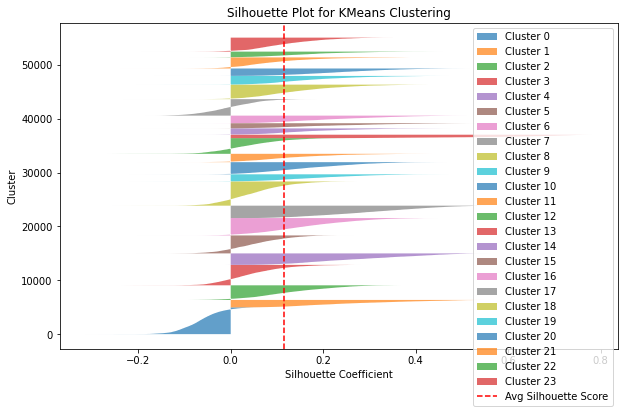

In [70]:
if len(set(df['Cluster'])) > 1:
    silhouette_vals = silhouette_samples(tfidf_reduced, df['Cluster'], metric='cosine')
    plt.figure(figsize=(10, 6))
    y_lower = 0
    for cluster in sorted(set(df['Cluster'])):
        cluster_sil_vals = np.sort(silhouette_vals[df['Cluster'] == cluster])
        y_upper = y_lower + len(cluster_sil_vals)
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_sil_vals, alpha=0.7, label=f'Cluster {cluster}')
        y_lower = y_upper
    plt.axvline(sil_score, color='red', linestyle='--', label='Avg Silhouette Score')
    plt.title('Silhouette Plot for KMeans Clustering')
    plt.xlabel('Silhouette Coefficient')
    plt.ylabel('Cluster')
    plt.legend()
    plt.savefig('silhouette_plot.png')
    plt.show()

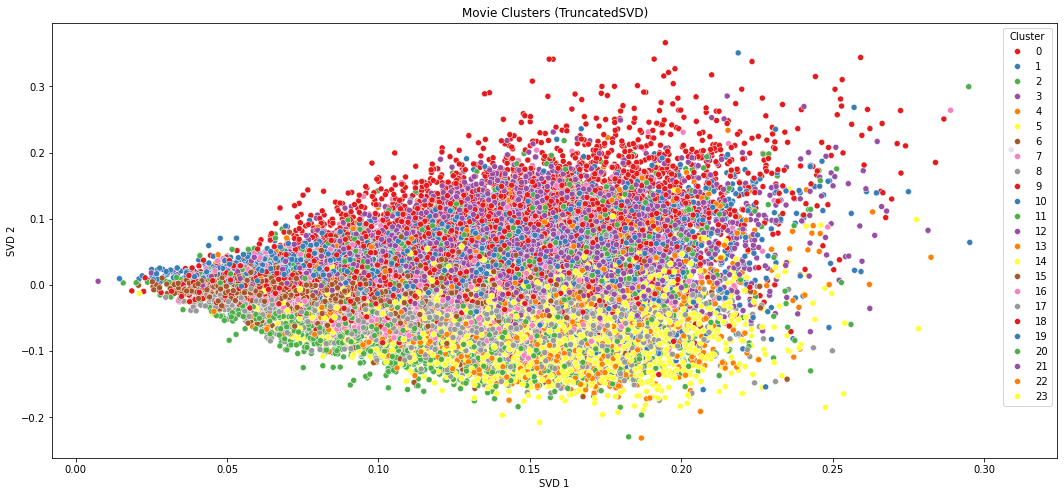

In [71]:
# Truncated SVD Visualization
svd_viz = TruncatedSVD(n_components=SVD_COMPONENTS, random_state=RANDOM_STATE)
svd_result = svd_viz.fit_transform(tfidf_matrix)
plt.figure(figsize=(18, 8))
sns.scatterplot(x=svd_result[:, 0], y=svd_result[:, 1], hue=df['Cluster'], palette='Set1', legend='full')
plt.title('Movie Clusters (TruncatedSVD)')
plt.xlabel('SVD 1')
plt.ylabel('SVD 2')
plt.savefig('svd_visualization.png')
plt.show()

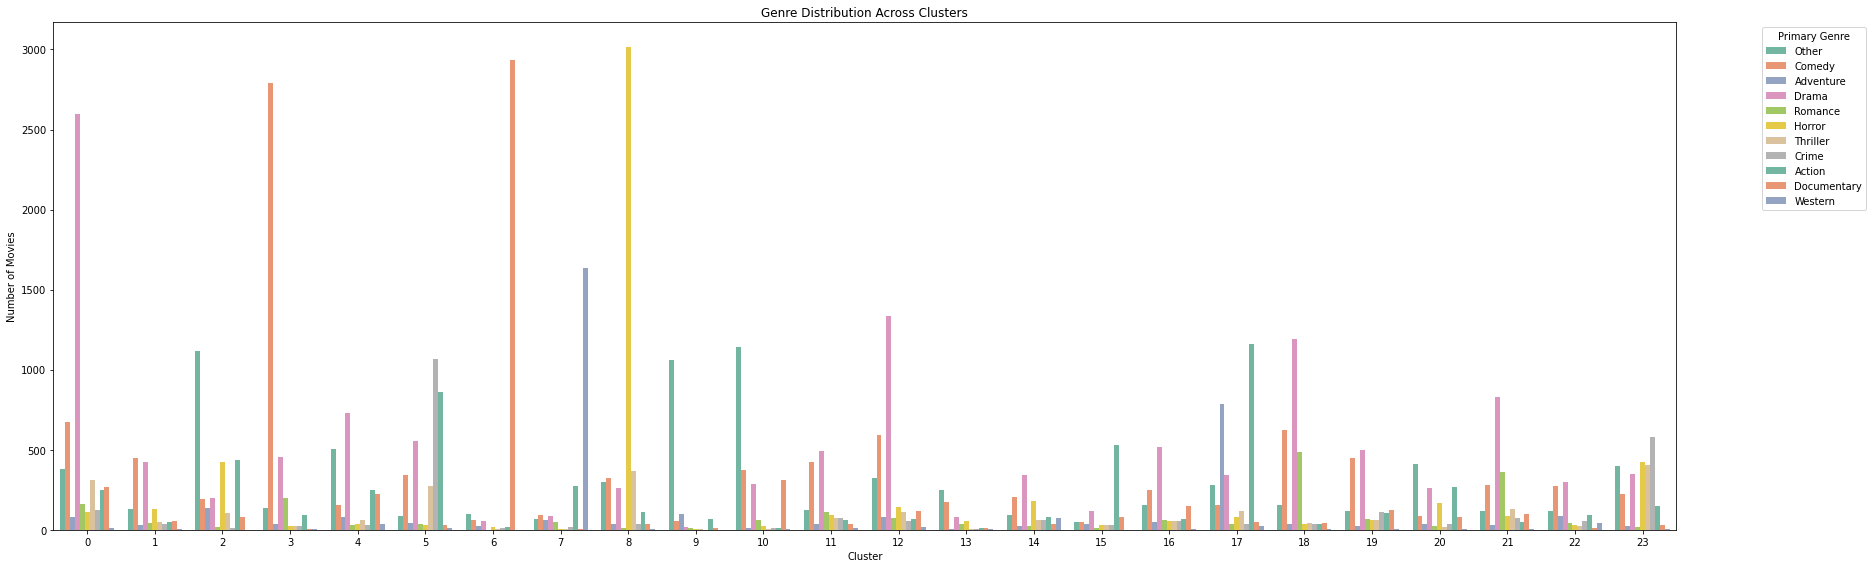

In [72]:
# --- GENRE DISTRIBUTION ---
plt.figure(figsize=(26, 8))
sns.countplot(data=df, x='Cluster', hue='PrimaryGenre', palette='Set2')
plt.title('Genre Distribution Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Movies')
plt.legend(title='Primary Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('genre_distribution.png')
plt.show()

In [73]:
# # --- WORD CLOUDS PER CLUSTER ---
# import os
# print(os.path.exists('/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf'))
# for cluster, group in df.groupby('Cluster'):
#     cluster_text = ' '.join(group['text'].astype(str))
#     wordcloud = WordCloud(
#         width=800, height=400, background_color='white', max_words=50,
# #         font_path='/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf'
#     ).generate(cluster_text)
#     plt.figure(figsize=(18, 8))
#     plt.imshow(wordcloud, interpolation='bilinear')
#     plt.title(f'Word Cloud for Cluster {cluster}')
#     plt.axis('off')
#     plt.savefig(f'wordcloud_cluster_{cluster}.png')
#     plt.show()

In [74]:
df

,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,budget,original_language,...,popularity,tagline,genres,production_companies,production_countries,spoken_languages,keywords,text,PrimaryGenre,Cluster
0,Inception,8.364,34495,Released,2010-07-15,825532764,148,False,160000000,en,...,83.952,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc...",inception cobb skilled thief commits corporate...,Action,17
1,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,False,165000000,en,...,140.241,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,...",interstellar adventure group explorer make use...,Adventure,2
2,The Dark Knight,8.512,30619,Released,2008-07-16,1004558444,152,False,185000000,en,...,130.643,Welcome to a world without rules.,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f...",dark knight batman raise stake war crime help ...,Drama,5
3,Avatar,7.573,29815,Released,2009-12-15,2923706026,162,False,237000000,en,...,79.932,Enter the world of Pandora.,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish","future, society, culture clash, space travel, ...",avatar 22nd century paraplegic marine dispatch...,Action,2
4,The Avengers,7.710,29166,Released,2012-04-25,1518815515,143,False,220000000,en,...,98.082,Some assembly required.,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"English, Hindi, Russian","new york city, superhero, shield, based on com...",avenger unexpected enemy emerges threatens glo...,Other,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230889,Blood-Red Ox,0.000,0,Released,2021-06-01,0,94,False,0,en,...,2.069,"In the glory of their fall, you can hear Baham...","Horror, Thriller",Kantrr Films,"Bolivia, United States of America","English, Spanish",gay theme,ox amir amat invited trip south american rain ...,Horror,8
1230962,Finding Courage,0.000,0,Released,2020-09-18,0,120,False,0,en,...,0.612,A true story of one family who dared to be free.,Documentary,Swoop Films,United States of America,"Mandarin, English",falun gong,finding courage former chinese journalist livi...,Documentary,12
1231160,Party in the Park 1999,0.000,0,Released,2002-05-02,0,155,False,0,en,...,0.914,Live Music! at Party In The Park 99,Music,"TDK Mediactive, Fun International Productions",United Kingdom,English,concert,party park 1999 location london hyde park date...,Other,10
1231161,Youp.,0.000,0,Released,2020-12-24,0,60,False,0,nl,...,0.600,Colleagues about the comedian in the run-up to...,"Documentary, Comedy",BNNVARA,Netherlands,Dutch,youp,youp colleague comedian last new year eve conf...,Documentary,19


In [84]:
import pandas as pd
import numpy as np

# Load the cleaned dataset
df = pd.read_csv('cleaned_movie_dataset.csv')

# Approximate sample size (since your system samples for clustering)
SAMPLE_SIZE = 15000  # or the size you used in your clustering sample

# If the dataset is smaller than SAMPLE_SIZE, just use the whole dataset
if len(df) < SAMPLE_SIZE:
    sampled_df = df
else:
    sampled_df = df.sample(SAMPLE_SIZE, random_state=42)

# Randomly select 5 movie titles from the sampled data
random_titles = sampled_df['title'].dropna().sample(5, random_state=42).tolist()

print("🎬 Here are 5 randomly selected movie titles:")
for i, title in enumerate(random_titles, 1):
    print(f"{i}. {title}")

🎬 Here are 5 randomly selected movie titles:
1. Cheer Squad Sleepovers
2. Monster High: The Movie
3. Oliver!
4. The Henderson Monster
5. Night Moves



Validating Recommendations for 'Night Moves':
Input Movie Details:
- Night Moves (Genre: Crime, Companies: Layton Productions, Hiller Productions, Warner Bros. Pictures): Private detective and former football player Harry Moseby gets hired on to what seems a standard mis...

Recommended Movies:
               title PrimaryGenre                                 production_companies  Similarity Score                                                                                                                                                                                                                                                                                                                                                                                 overview  vote_average  popularity
     Twenty Plus Two        Crime Allied Artists Pictures, Scott R. Dunlap Productions          0.745960                                                                                           

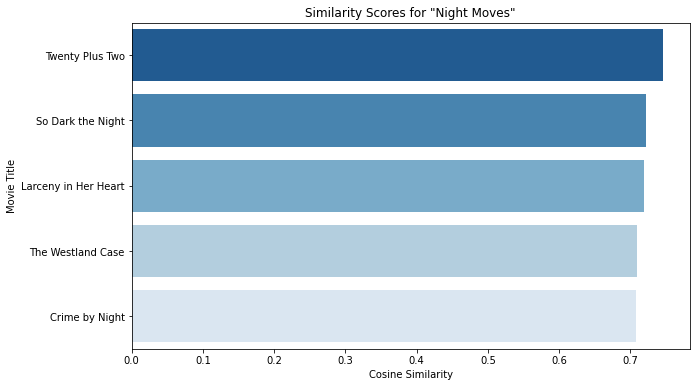

In [89]:
sample_movie = 'Night Moves'
print(f"\nValidating Recommendations for '{sample_movie}':")
if df['title'].str.lower().eq(sample_movie.lower()).any():
    movie_info = df[df['title'].str.lower() == sample_movie.lower()].iloc[0]
    print(f"Input Movie Details:\n- {movie_info['title']} (Genre: {movie_info['PrimaryGenre']}, Companies: {movie_info['production_companies']}): {movie_info['overview'][:100]}...")
    recs = recommend_content(sample_movie, top_n=TOP_N)
    if isinstance(recs, str):
        print(recs)
    else:
        print("\nRecommended Movies:")
        print(recs[['title', 'PrimaryGenre', 'production_companies', 'Similarity Score', 'overview', 'vote_average', 'popularity']].to_string(index=False))
    
        neighbor_indices = recs.index
        sim_scores = recs['Similarity Score']
        top_titles = recs['title'].values

        plt.figure(figsize=(10, 6))
        sns.barplot(x=sim_scores, y=top_titles, palette='Blues_r')
        plt.title(f'Similarity Scores for \"{sample_movie}\"')
        plt.xlabel('Cosine Similarity')
        plt.ylabel('Movie Title')
        plt.savefig('similarity_scores.png')
        plt.show()
else:
    print(f"Movie '{sample_movie}' not found in dataset.")

In [77]:
df.to_csv('cleaned_movie_dataset.csv', index=False)

In [4]:
import pandas as pd

# Replace 'your_dataset.csv' with the path to your CSV file
df = pd.read_csv('./CSVs/cleaned_movie_dataset.csv', nrows=40000)

# Now df contains only the first 8000 rows of your dataset
print(df.shape)  # Should print (8000, number_of_columns)

# If you want to save these 8000 rows to a new CSV:
df.to_csv('movie_dataset_cleaned.csv', index=False)

(40000, 22)
